In [15]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import functools
from anndata import AnnData
import scvi
import torch

In [7]:
from scvi.module.base import (
    BaseMinifiedModeModuleClass,
    EmbeddingModuleMixin,
    LossOutput,
    auto_move_data,
)

from scvi.nn import Encoder

In [308]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def cosine_similarity_rows(A: np.array, B: np.array) -> np.array:
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def benchmark_reconstruction(count_matrix: np.array, count_matrix_reconstructed: np.array) -> None:

    if isinstance(count_matrix, torch.Tensor):
        count_matrix = count_matrix.detach().numpy()
    if isinstance(count_matrix_reconstructed, torch.Tensor):
        count_matrix_reconstructed = count_matrix_reconstructed.detach().numpy()

    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

In [134]:
celltype = "Stem/TA"
adata_sp = (lambda x: x[x.obs["nico_ct"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
#adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = (lambda x: x[x.obs["cluster"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad"))
#adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
#sc.pp.filter_genes(adata_sp, min_counts=50)
#sc.pp.filter_genes(adata_sc, min_counts=50)
sc.pp.filter_genes(adata_sp, min_counts=20)
sc.pp.filter_genes(adata_sc, min_counts=20)
shared_genes_mask_sc = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes_mask_sp = np.isin(adata_sp.var_names, adata_sc.var_names)
shared_genes = adata_sc[:, shared_genes_mask_sc].var_names
print(f"{len(shared_genes)=}")

len(shared_genes)=63


In [82]:
test = Encoder(500, 20)

In [77]:
test

Encoder(
  (encoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=500, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): ReLU()
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mean_encoder): Linear(in_features=128, out_features=5, bias=True)
  (var_encoder): Linear(in_features=128, out_features=5, bias=True)
)

In [100]:
test(torch.Tensor(np.random.choice(6, (5, 500))))

(tensor([[ 0.2707,  0.2716,  0.1835, -0.8152, -0.5691,  0.2334,  0.4311, -0.1974,
          -0.7923,  0.0686,  0.0535,  0.1869, -0.3502, -0.6685, -0.0800, -0.2804,
           0.5972,  0.0266,  0.1404,  0.1450],
         [-0.2030,  0.0204, -0.2617, -0.0540,  0.5519,  0.5944,  0.1459, -0.4703,
           0.3763, -0.1618,  0.1599, -0.0849, -0.1776, -0.8348, -0.1439, -0.2192,
           0.2352, -0.1435, -0.3928,  0.8761],
         [ 0.2051,  0.3908,  0.4689,  0.4281,  0.2533,  0.3096, -0.2291,  0.3745,
          -1.0022,  0.6039,  0.3999, -0.0825,  0.1633, -0.0104,  0.5029, -0.0149,
           0.4248,  0.0852,  0.1059,  0.2847],
         [-0.5079,  0.2069, -0.1378, -0.6826, -0.2433,  0.8579, -0.0382,  0.1856,
          -0.1953, -0.0665,  0.6361, -0.2208,  0.1413, -0.5289,  0.6177, -0.3866,
           0.7556,  0.2297, -0.2532,  1.2899],
         [ 0.3289,  0.3520,  0.3010, -0.2705,  0.2711,  0.2355, -0.1345, -0.2280,
           0.0914,  0.9649, -0.4682, -0.0457, -0.0699, -0.1219, -0.5337, -

In [101]:
from scvi.nn import Encoder

In [108]:
from typing import Literal
class MyNeuralNet2(torch.nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        link_var: Literal["exp", "none", "softmax"],
    ):
        """Encodes data of ``n_input`` dimensions into a space of ``n_output`` dimensions.

        Uses a one layer fully-connected neural network with 128 hidden nodes.

        Parameters
        ----------
        n_input
            The dimensionality of the input.
        n_output
            The dimensionality of the output.
        link_var
            The final non-linearity.
        """
        super().__init__()
        self.neural_net = torch.nn.Sequential(
            #torch.nn.Linear(n_input, 128),
            #torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),
            #torch.nn.Linear(128, n_output)
            torch.nn.Linear(n_input, n_output)
        )
        self.transformation = None
        if link_var == "softmax":
            self.transformation = torch.nn.Softmax(dim=-1)
        elif link_var == "exp":
            self.transformation = torch.exp

    def forward(self, x: torch.Tensor):
        output = self.neural_net(x)
        if self.transformation:
            output = self.transformation(output)
        return output

In [110]:
MyNeuralNet2(20, 2, "softmax")

MyNeuralNet2(
  (neural_net): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
  (transformation): Softmax(dim=-1)
)

In [111]:
Encoder(200,3)

Encoder(
  (encoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=200, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): ReLU()
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mean_encoder): Linear(in_features=128, out_features=3, bias=True)
  (var_encoder): Linear(in_features=128, out_features=3, bias=True)
)

In [71]:
class Linear_scvi_integration(EmbeddingModuleMixin, BaseMinifiedModeModuleClass):

    def __init__(
            self, 
            *args, 
            **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.encoder = Encoder()

In [122]:
adata_sc[:, shared_genes_mask_sc].var_names

Index(['Fzd7', 'Fzd5', 'Cps1', 'Gpr55', 'Mptx2', 'Vim', 'Cd44', 'Ada',
       'Tm4sf4', 'Clca3b', 'Lpar1', 'Marcksl1', 'Stmn1', 'C1qb', 'C1qc',
       'Ccnl2', 'Fzd1', 'Slc5a1', 'Kit', 'Gper1', 'Smo', 'Lrmp', 'Klk1',
       'Fzd4', 'Itgam', 'Mki67', 'Nlrp6', 'Trpm5', 'Acsl1', 'Hmgb2', 'Jaml',
       'Cmc1', 'Lgr5', 'Avil', 'Ccl9', 'Fzd2', 'Cd79b', 'Sdc1', 'Agr3',
       'Tspan13', 'Net1', 'Chrm3', 'Sox4', 'Txndc5', 'Il3ra', 'Lpar6',
       'Ptger4', 'Fzd6', 'Krt7', 'Slc51a', 'Ifnar1', 'H2-Eb1', 'Tnfrsf21',
       'Fzd8', 'Cd14', 'Slc12a2', 'Htr4', 'Neat1', 'Rcor2', 'Ffar4', 'Adra2a',
       'Maoa', 'Maged2'],
      dtype='object')

In [124]:
adata_sp[:, shared_genes].var_names

Index(['Fzd7', 'Fzd5', 'Cps1', 'Gpr55', 'Mptx2', 'Vim', 'Cd44', 'Ada',
       'Tm4sf4', 'Clca3b', 'Lpar1', 'Marcksl1', 'Stmn1', 'C1qb', 'C1qc',
       'Ccnl2', 'Fzd1', 'Slc5a1', 'Kit', 'Gper1', 'Smo', 'Lrmp', 'Klk1',
       'Fzd4', 'Itgam', 'Mki67', 'Nlrp6', 'Trpm5', 'Acsl1', 'Hmgb2', 'Jaml',
       'Cmc1', 'Lgr5', 'Avil', 'Ccl9', 'Fzd2', 'Cd79b', 'Sdc1', 'Agr3',
       'Tspan13', 'Net1', 'Chrm3', 'Sox4', 'Txndc5', 'Il3ra', 'Lpar6',
       'Ptger4', 'Fzd6', 'Krt7', 'Slc51a', 'Ifnar1', 'H2-Eb1', 'Tnfrsf21',
       'Fzd8', 'Cd14', 'Slc12a2', 'Htr4', 'Neat1', 'Rcor2', 'Ffar4', 'Adra2a',
       'Maoa', 'Maged2'],
      dtype='object')

In [117]:
len(shared_genes)

47

In [243]:
class Gene_Predictor(torch.nn.Module):
    def __init__(
            self,
            n_input,
            n_latent,
            n_output,
            *args,
            **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_input, n_latent),
            torch.nn.ReLU(),
            torch.nn.Linear(n_latent, n_output),
            torch.nn.ReLU(),
        )

        self.encoder = torch.nn.Linear(
            n_input,
            n_latent,
        )
        self.decoder = torch.nn.Linear(
            n_latent,
            n_output,
        )
    
    def forward(self, x):
        return self.net(x)

In [232]:
output_sp = []
output_sc = []
for gene in shared_genes:
    X, y = (lambda x, mask: (torch.Tensor(x[:, ~mask]), torch.Tensor(x[:, mask]).unsqueeze(1)))(
        x=adata_sc.X.toarray()[:, shared_genes_mask_sc],
        mask=np.isin(shared_genes, gene)
    )
    model = Gene_Predictor(
        n_input=len(shared_genes) - 1,
        n_latent=100,
        n_output=1
    )
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    for _ in range(100):
        model.train()
        outputs = model(X)
        loss = criterion(outputs, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    #output.append(model(X).detach().numpy())
    output_sp.append(
        model(
            torch.Tensor(
                adata_sp[:, shared_genes].X.toarray()[:, ~np.isin(shared_genes, gene)]
            )
        ).detach().numpy()
    )
    output_sc.append(model(X).detach().numpy())


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([420, 1, 1, 1])) that is different to the input size (torch.Size([420, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/38523167.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


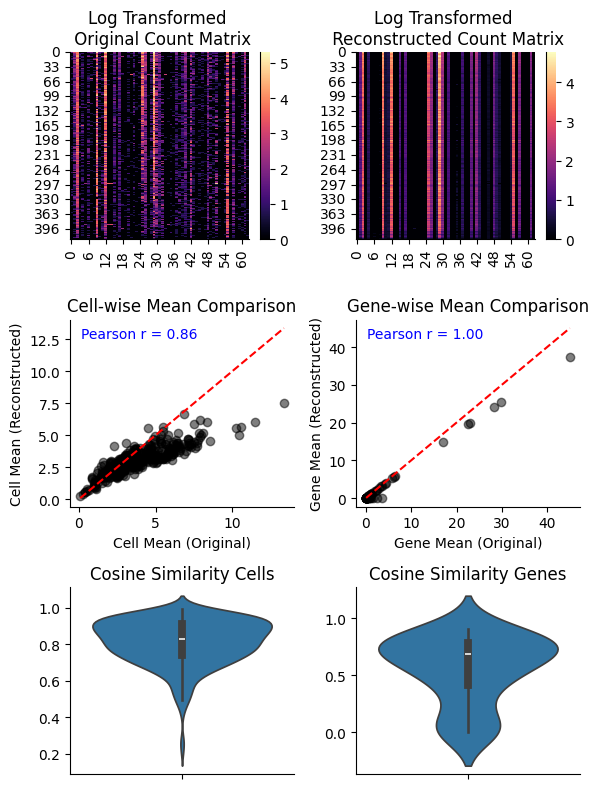

In [233]:
benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X.toarray(), np.hstack(output_sc))

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/38523167.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


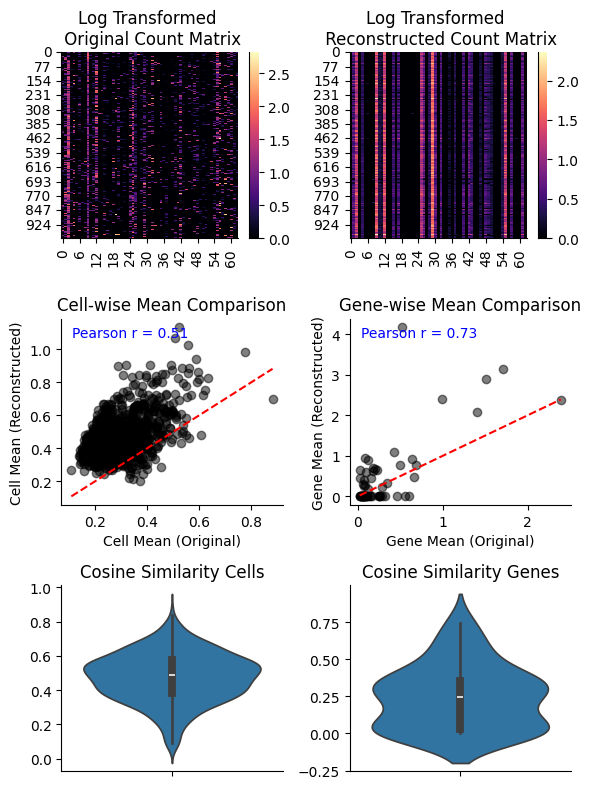

In [234]:
benchmark_reconstruction(adata_sp[:, shared_genes].X.toarray(), np.hstack(output_sp))

In [305]:
model2 = Gene_Predictor(
    n_input=len(shared_genes),
    n_latent=20,
    n_output=len(shared_genes)
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

X = torch.Tensor(adata_sc.X.toarray()[:, shared_genes_mask_sc])

for _ in range(100):
    model2.train()
    outputs = model2(X)
    loss = criterion(outputs, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/38523167.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


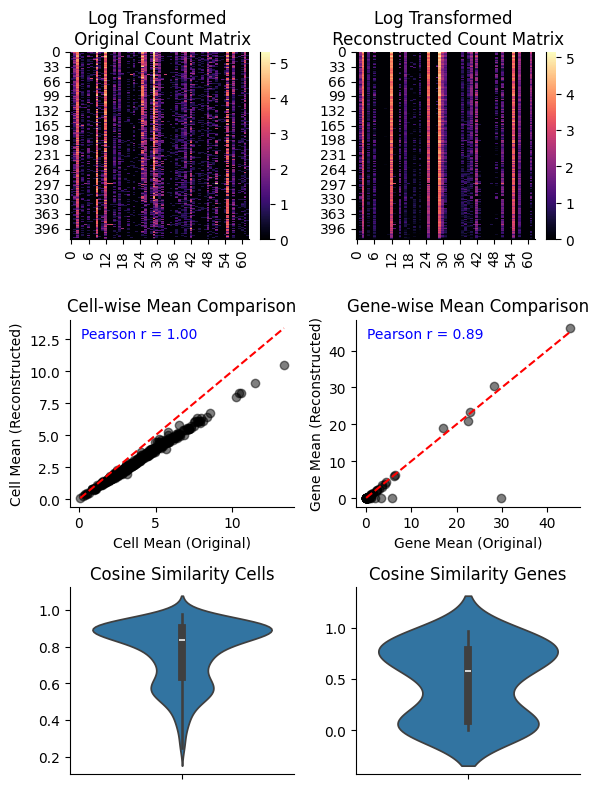

In [306]:
# evaluating the reconstruction quality of the single cell data
benchmark_reconstruction(X.detach().numpy(), model2(X).detach().numpy())

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1094689195.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


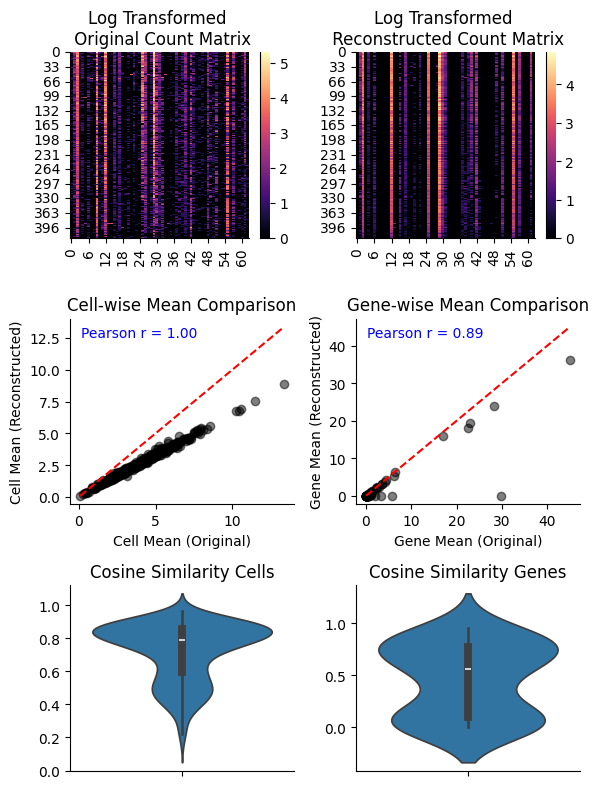

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_30187/1094689195.py:15: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


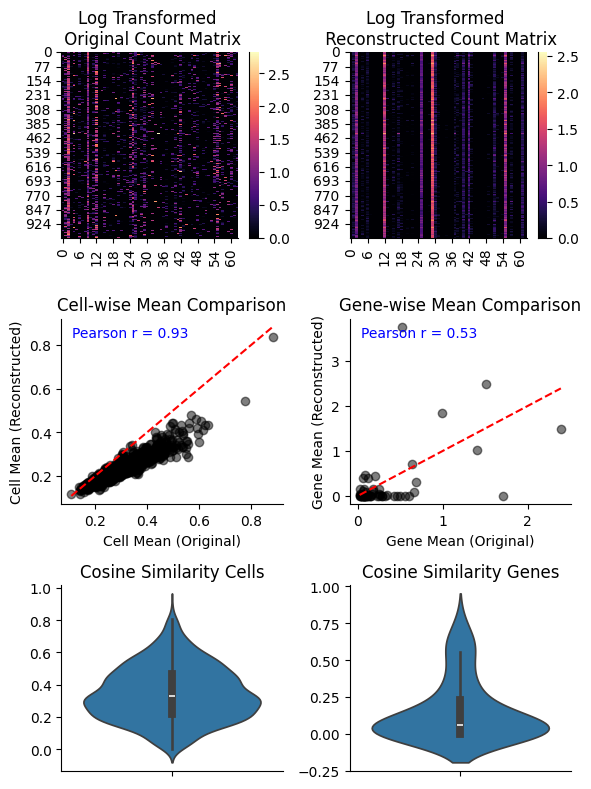

In [311]:
# iteratively reconstructing the original matrix by evaluating the autoencoder on the dataset but setting the counts of individual genes to 0

# the single cell data used for training
benchmark_reconstruction(
    adata_sc.X.toarray()[:, shared_genes_mask_sc],
    torch.hstack([model2(torch.Tensor(np.where(~np.isin(shared_genes, gene), adata_sc.X.toarray()[:, shared_genes_mask_sc], 0)))[:, np.isin(shared_genes, gene)] for gene in shared_genes])
)

# the spatial count matrix
benchmark_reconstruction(
    adata_sp[:, shared_genes].X.toarray(),
    torch.hstack([model2(torch.Tensor(np.where(~np.isin(shared_genes, gene), adata_sp[:, shared_genes].X.toarray(), 0)))[:, np.isin(shared_genes, gene)] for gene in shared_genes])
)